<a href="https://colab.research.google.com/github/hijuliosantos/pos-NN/blob/main/TrabalhoFinalTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este trabalho tem como objetivo utilizar a biblioteca de aprendizado de máquina "PyTorch" com o objetivo de criar diferentes arquiteturas de redes neurais para a classificação de granulometria e compará-las. Para este trabalho, utilizou-se a base "lithology.csv" criada por um time de especialistas em litologia. 

A base contém 1.170.511 exemplos, 30 variáveis preditoras e uma variável a ser predita, contendo 12 classes granulométricas.







# Inicío da execução do trabalho

Inicialmente realizo a importação das bibliotecas necessárias para o desenvolvimento deste trabalho.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

Os dados estão no google Drive, com isto, utilizo o seguinte código para utilizar o drive no colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/datasets/

/content/drive/My Drive/datasets


Leitura dos dados através da biblioteca pandas.

In [ ]:
df = pd.read_csv('lithology.csv', delimiter=';')
print('Shape da base', df.shape)

Shape da base (1170511, 31)


Faço uma pequena análise em alguns dados (etapas de pré-processamento já executadas).

In [ ]:
pd.set_option('display.max_columns', 31)
df.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,ROP,DCAL,DRHO,MUDWEIGHT,RMIC,FORCE_2020_LITHOFACIES_LITHOLOGY,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,-999.0,20.915468,161.131180,24.612379,17.5,34.636410,1.980835,-0.574928,-999.0,-999.0,65000.0,24.735691,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,-999.0,19.383013,160.603470,23.895531,17.5,34.636410,1.968800,-0.570188,-999.0,-999.0,65000.0,24.492376,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,-999.0,22.591518,160.173615,23.916357,17.5,34.779556,1.968800,-0.574245,-999.0,-999.0,65000.0,24.202299,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,-999.0,32.191910,160.149429,23.793688,17.5,39.965164,1.959282,-0.586315,-999.0,-999.0,65000.0,24.400797,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,-999.0,38.495632,160.128342,24.104078,17.5,57.483765,1.953100,-0.597914,-999.0,-999.0,65000.0,24.916765,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 31 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   DEPTH_MD                          1170511 non-null  float64
 1   X_LOC                             1170511 non-null  float64
 2   Y_LOC                             1170511 non-null  float64
 3   Z_LOC                             1170511 non-null  float64
 4   CALI                              1170511 non-null  float64
 5   RSHA                              1170511 non-null  float64
 6   RMED                              1170511 non-null  float64
 7   RDEP                              1170511 non-null  float64
 8   RHOB                              1170511 non-null  float64
 9   GR                                1170511 non-null  float64
 10  NPHI                              1170511 non-null  float64
 11  PEF                               117

In [ ]:
df['FORMATION_encoded'].value_counts()

 68    254998
 37     94328
 38     71080
 24     65041
-1      54632
        ...  
 6        235
 30       177
 17       171
 19       118
 13       105
Name: FORMATION_encoded, Length: 70, dtype: int64

In [ ]:
df['GROUP_encoded'].value_counts()

5     293155
9     234028
12    131999
7     131944
3     119085
6     112768
2      52320
0      35823
11     26116
4      13913
13     12238
1       3125
8       2792
10      1205
Name: GROUP_encoded, dtype: int64

In [ ]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()

65000.0    720803
30000.0    168937
65030.0    150455
70000.0     56320
80000.0     33329
99000.0     15245
70032.0     10513
88000.0      8213
90000.0      3820
74000.0      1688
86000.0      1085
93000.0       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

A partir da análise incial, irei padronizar a variável a ser predita "FORCE_2020_LITHOFACIES_LITHOLOGY" para valores de 0 até 11, devido aos seus valores originais estarem despadronizados. 

In [ ]:
lithology_dict = {30000: 1, 65030: 2, 65000: 0, 80000: 4, 74000: 9, 70000: 3, 70032: 6, 
                  88000: 7, 86000: 10, 99000: 5, 90000: 8, 93000: 11}

def map_lithology(dict_lithology, row) -> str:
    key = row['FORCE_2020_LITHOFACIES_LITHOLOGY']
    return dict_lithology[key]

df['LITHOLOGY_MAP'] = df.apply(lambda row: map_lithology(lithology_dict, row), axis=1)
df['LITHOLOGY_MAP'].value_counts()

0     720803
1     168937
2     150455
3      56320
4      33329
5      15245
6      10513
7       8213
8       3820
9       1688
10      1085
11       103
Name: LITHOLOGY_MAP, dtype: int64

In [ ]:
df.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'Carbon_Index',
       'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
       'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
       'FORMATION_encoded', 'LITHOLOGY_MAP'],
      dtype='object')

Configurações para reprodutibilidade

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
#random.seed(seed) 
# for cuda
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

Habilitar GPU cuda se disponível.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Divido o meu dataset em 80% treino e mantenho 20% para testes. Esses 20% de testes, divido metade para testes ea outra metade para validação. Com isto, obtenho 80% treino / 10% validação / 10% testes. Foi estratificada a varíavel a ser predita nos splits. 

In [ ]:
X = df[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
        'Carbon_Index', 'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB', 'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded', 'FORMATION_encoded']]

y = df['LITHOLOGY_MAP']

# DIVIDIR DATASET EM 80/10/10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed, shuffle=True)

Realizo os ajustes nas variáveis preditoras. 

Para os valores numéricos irei utilizar MinMaxScaler e os valores categóricos irei utilizar OneHotEncoder.

In [ ]:
# NORMALIZAR OS DADOS
min_max_scaler = preprocessing.MinMaxScaler()

X_train_mm = min_max_scaler.fit_transform(X_train[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',  'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP',
        'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'Carbon_Index', 'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB', 'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index'
        ]])

X_test_mm = min_max_scaler.transform(X_test[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',  'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP',
        'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'Carbon_Index', 'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB', 'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index'
        ]])

X_val_mm = min_max_scaler.transform(X_val[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',  'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP',
        'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'Carbon_Index', 'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB', 'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index'
        ]])

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train[['GROUP_encoded', 'FORMATION_encoded']])
X_test_ohe = ohe.transform(X_test[['GROUP_encoded', 'FORMATION_encoded']])
X_val_ohe = ohe.transform(X_val[['GROUP_encoded', 'FORMATION_encoded']])

# GERAR O DATASET
X_train = np.hstack([ X_train_mm, X_train_ohe])
X_test = np.hstack([ X_test_mm, X_test_ohe])
X_val = np.hstack([ X_val_mm, X_val_ohe])

Organizo meus datasets de treino, teste e validação. Também realizo a conversão dos dados para tensor, afim de serem utilizados em modelos de redes neurais do pytorch.

In [ ]:
class ClassifierDataset (Dataset): 
    def __init__ (self, X_data, y_data): 
        self.X_data = X_data 
        self.y_data = y_data 
        
    def __getitem__ (self, index): 
        return self.X_data [index], self.y_data [index] 
        
    def __len__ (self): 
        return len (self.X_data) 


train_dataset = ClassifierDataset (torch.from_numpy (X_train) .float (), torch.from_numpy (y_train.to_numpy()) .long ())
val_dataset = ClassifierDataset (torch.from_numpy (X_val) .float (), torch.from_numpy (y_val.to_numpy()) .long ())
test_dataset = ClassifierDataset (torch.from_numpy (X_test) .float (), torch.from_numpy (y_test.to_numpy()) .long ())

# tamanho da entrada (utilizado para a rede neural)
NUM_FEATURES = X_train.shape[1]
# quantidade de classes que posso obter (utilizado para a rede neural)
NUM_CLASSES = len(y.value_counts())

Método "execute_test_model" utilizado para executar o teste do modelo e exibir a acurácia após o treinamento e validação

In [ ]:
def execute_test_model(model: nn.Sequential, test_loader: DataLoader) -> None:
  acc_test = 0.00
  test_accuracy_general = []
  #desativa calculo do gradiente (para modo evaluation) 
  with torch.no_grad():
    
    model.eval() #ativa modo evaluation
    for i, (data_test, labels_test) in enumerate(test_loader):
        data_test, labels_test = data_test.to(device), labels_test.to(device)
        y_pred_test = model(data_test)
                  
        classes_test = torch.argmax(y_pred_test, dim=1)
        acc_test += torch.mean((classes_test == labels_test).float())
        test_accuracy_general.append(acc_test/len(test_loader))
        
  print("Acurácia de teste: {:.2f}%".format(acc_test/len(test_loader) * 100))

In [ ]:
def plot_loss_acc(train_losses_general: list, val_losses_general: list, train_accuracy_general: list, val_accuracy_general: list) -> None:
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
  axes[0].plot(train_losses_general, label='Training loss')
  axes[0].plot(val_losses_general, label='Validation loss')
  axes[0].legend(frameon=False)

  axes[1].plot(train_accuracy_general, label='Training acc')
  axes[1].plot(val_accuracy_general, label='Validation acc')
  axes[1].legend(frameon=False)
  plt.show()

Método "execute_model" responsável por executar o modelo. Ele recebe um modelo pytorch e um dicionário contendo parâmetros para a execução desse modelo.

Execução:

1.   Inicialmente os dados são preparados para utilizarem BATCH
2.   Impresssão dos shapes dos dataset de treino, validação e teste
3.   Criada a função de perda passada através do dict
4.   Criada a função de otimização passada através do dict
5.   Transferência do modelo para GPU se houver. Impressão da arquitetura do modelo
6.   Realizado um loop na quantidade de épocas passadas través do dict
7.   Para cada época, é realizado o treinamento do modelo, calculada a loss e acurácia. Também é realizada a validação com os 10% da base (o treinamento é desativado para a validação)
8. Ao final do treinamento, são impressos dois gráficos apresentando a evolução da loss e acurácia por época
9. Finalizando o método, é realizada a predição do modelo gerado com a base de testes (10%). São impressas as acurácias de todos os datasets: treino, validação e teste. A acurácia é utilizada para a avaliação do modelo.



In [ ]:
def execute_model(model: nn.Sequential, dict_params: dict) -> None:
  # Crio o loader para aplicar batches nos datasets
  train_loader = DataLoader(dataset=train_dataset, batch_size=dict_params['BATCH_SIZE'], shuffle=False)
  val_loader = DataLoader(dataset=val_dataset, batch_size=dict_params['BATCH_SIZE'], shuffle=False)
  test_loader = DataLoader(dataset=test_dataset, batch_size=dict_params['BATCH_SIZE'], shuffle=False)

  # Imprimo o shape dos datasets para conferir se os dados estão distribuídos corretamente
  print('Shape X_train', X_train.shape)
  print('Shape y_train', y_train.shape)
  print('Shape X_val', X_val.shape)
  print('Shape y_val', y_val.shape)
  print('Shape X_test', X_test.shape)
  print('Shape y_test', y_test.shape)
  print('Len DF original', len(df))
  print('Len train + val + test', len(X_train) + len(X_val) + len(X_test))

  # Crio a função de perda e o otimizador com base no que foi passado pelo dict
  criterion = dict_params['CRITERION']
  optimizer = None
  if dict_params['OPTIMIZER'] == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=dict_params['LEARNING_RATE']) #weight_decay=0.03
  elif dict_params['OPTIMIZER'] == 'SGD': 
    optimizer = torch.optim.SGD(model.parameters(), lr=dict_params['LEARNING_RATE'])

  #  Transfiro o modelo para cpu ou gpu e imprimo ele
  model.to(device)
  print(model)

  # Percorrer a quantidade de épocas passadas pelo dict
  train_losses_general, val_losses_general, train_accuracy_general, val_accuracy_general = [], [], [], []
  for e in range(dict_params['EPOCHS']):
      train_loss, acc_train = 0.00, 0.00     

      # Percorre os batches de treino, faz a predição, calcula a loss e a acurácia
      for data, labels, in train_loader:
          data, labels = data.to(device), labels.to(device)
          #forward propagation
          y_train_pred = model(data)
          loss = criterion(y_train_pred, labels)

          #zera o gradiente do otimizador
          optimizer.zero_grad()
          
          #backpropagation
          loss.backward()
          optimizer.step()

          train_loss += loss.item()

          classes = torch.argmax(y_train_pred, dim=1)
          acc_train += torch.mean((classes == labels).float())
        
      
      # IMPORTANTE: é necessário desativar o cálculo de gradiente, pois, o modelo não pode considerar os dados de validação
      val_loss, acc_val = 0.00, 0.00
      with torch.no_grad(): #desativa calculo do gradiente (para modo evaluation) 
        model.eval() #ativa modo evaluation
        
        # Percorre os batches de validação, faz a predição, calcula a loss e a acurácia. 
        for data_val, labels_val in val_loader:
          data_val, labels_val = data_val.to(device), labels_val.to(device)
          y_val_pred = model(data_val)
          val_loss += criterion(y_val_pred, labels_val)
                  
          classes_val = torch.argmax(y_val_pred, dim=1)
          acc_val += torch.mean((classes_val == labels_val).float())
          
      # Acumula as métricas para posterior impressão de gráficos
      train_losses_general.append(train_loss/len(train_loader))
      val_losses_general.append(val_loss/len(val_loader))
      train_accuracy_general.append(acc_train/len(train_loader))
      val_accuracy_general.append(acc_val/len(val_loader))

      # Impressão da época/loss/acc de treino e validação
      print("Epoch: {}/{}.. ".format(e+1,dict_params['EPOCHS']),
                  "Train Loss: {:.4f}.. ".format(train_loss/len(train_loader)),
                  "Val Loss: {:.4f}.. ".format(val_loss/len(val_loader)),
                  "Train Acc: {:.4f}.. ".format(acc_train/len(train_loader)),
                  "Val Acc: {:.4f}.. ".format(acc_val/len(val_loader)))

      #ativa o modo de treino novamente após desativa-lo para validação
      model.train()

  # Impressão da loss/acc por época nos treinos e validações
  plot_loss_acc(train_losses_general, val_losses_general, train_accuracy_general, val_accuracy_general)

  # Executo o teste do modelo e imprimo a relação de acurácias
  execute_test_model(model, test_loader)
  print("Acurácia de treinamento: {:.2f}%".format(acc_train/len(train_loader) * 100))
  print("Acurácia de validação: {:.2f}%".format(acc_val/len(val_loader) * 100))

# **Abaixo serão realizados os experimentos**

PRIMEIRO MODELO: Rede neural com:


*   Camada de entrada com 128 neurônios
*   Função de ativação ReLU
*   Camada de saída

Utilizarei 10 épocas, batch size de 512, LR de 0.05, função de otimização SGD e perda CrossEntropyLoss

Shape X_train (936408, 112)
Shape y_train (936408,)
Shape X_val (117052, 112)
Shape y_val (117052,)
Shape X_test (117051, 112)
Shape y_test (117051,)
Len DF original 1170511
Len train + val + test 1170511
Sequential(
  (0): Linear(in_features=112, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=12, bias=True)
)
Epoch: 1/10..  Train Loss: 0.9874..  Val Loss: 0.8260..  Train Acc: 0.6659..  Val Acc: 0.7120.. 
Epoch: 2/10..  Train Loss: 0.7894..  Val Loss: 0.7634..  Train Acc: 0.7247..  Val Acc: 0.7333.. 
Epoch: 3/10..  Train Loss: 0.7502..  Val Loss: 0.7343..  Train Acc: 0.7365..  Val Acc: 0.7380.. 
Epoch: 4/10..  Train Loss: 0.7249..  Val Loss: 0.7107..  Train Acc: 0.7430..  Val Acc: 0.7472.. 
Epoch: 5/10..  Train Loss: 0.7046..  Val Loss: 0.6872..  Train Acc: 0.7509..  Val Acc: 0.7580.. 
Epoch: 6/10..  Train Loss: 0.6913..  Val Loss: 0.6681..  Train Acc: 0.7566..  Val Acc: 0.7674.. 
Epoch: 7/10..  Train Loss: 0.6784..  Val Loss: 0.6529..  Train Acc

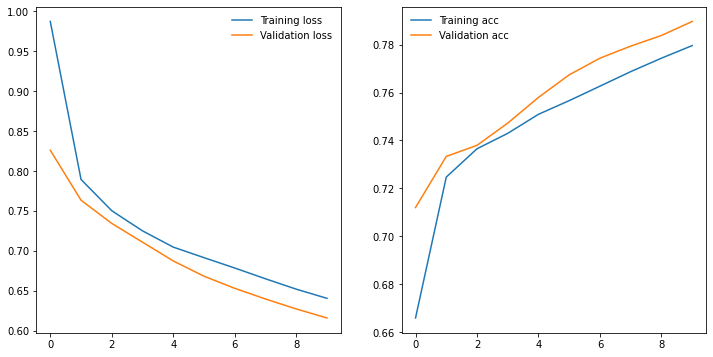

Acurácia de teste: 79.02%
Acurácia de treinamento: 77.96%
Acurácia de validação: 78.96%


In [ ]:
params1 = dict()
params1['EPOCHS'] = 10
params1['BATCH_SIZE'] = 512
params1['LEARNING_RATE'] = 0.05
params1['CRITERION'] = nn.CrossEntropyLoss()
params1['OPTIMIZER'] = 'SGD'

model1 = nn.Sequential(
          nn.Linear(NUM_FEATURES, 128),
          nn.ReLU(),
          nn.Linear(128, NUM_CLASSES)
        )

execute_model(model1, params1)

# Análise do resultado do primeiro modelo



Com base nos gráficos, podemos ver que a loss foi diminuindo e a acurácia foi aumentado conforme passos das épocas. Não apresenta overfitting ou underfitting. Poderá ser aumentada as épocas e até tentar outros experimentos com mais camadas e neurônios.

Olhando para a acurácia e até mesmo para a loss no gráfico, podemos notar que a validação está um pouquinho melhor que o treino. Isso poderia acontecer caso não houvesse a desabilitação do treinamento no pytorch, mas não é o caso. Para tentar adequar os valores, tentarei diminuir o tamanho do batch (como o dataset de validação é menor e os dados estão se ajustando bem, diminuir o batch fará utilizar mais registros) ou ajustar a learning rate.


---



Segundo modelo: Rede neural com:


*   Camada de entrada com 128 neurônios
*   Função de ativação ReLU
*   Camada de saída

Utilizarei 50 épocas, batch size de 64, LR de 0.05, função de otimização SGD e perda CrossEntropyLoss

Shape X_train (936408, 112)
Shape y_train (936408,)
Shape X_val (117052, 112)
Shape y_val (117052,)
Shape X_test (117051, 112)
Shape y_test (117051,)
Len DF original 1170511
Len train + val + test 1170511
Sequential(
  (0): Linear(in_features=112, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=12, bias=True)
)
Epoch: 1/50..  Train Loss: 0.7578..  Val Loss: 0.7933..  Train Acc: 0.7341..  Val Acc: 0.7145.. 
Epoch: 2/50..  Train Loss: 0.6201..  Val Loss: 0.7599..  Train Acc: 0.7872..  Val Acc: 0.7344.. 
Epoch: 3/50..  Train Loss: 0.5674..  Val Loss: 0.6886..  Train Acc: 0.8087..  Val Acc: 0.7594.. 
Epoch: 4/50..  Train Loss: 0.5362..  Val Loss: 0.6355..  Train Acc: 0.8202..  Val Acc: 0.7771.. 
Epoch: 5/50..  Train Loss: 0.5139..  Val Loss: 0.6062..  Train Acc: 0.8274..  Val Acc: 0.7880.. 
Epoch: 6/50..  Train Loss: 0.4966..  Val Loss: 0.5670..  Train Acc: 0.8332..  Val Acc: 0.8042.. 
Epoch: 7/50..  Train Loss: 0.4833..  Val Loss: 0.5407..  Train Acc

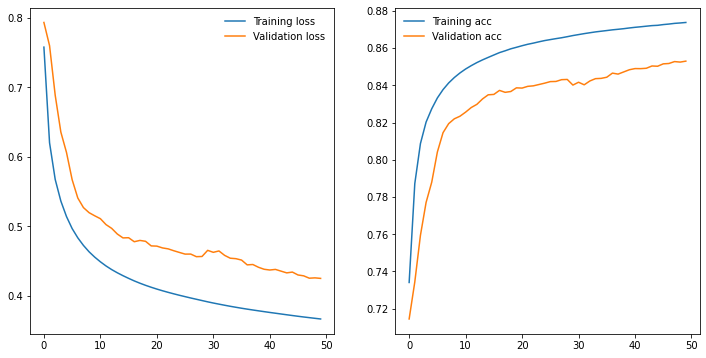

Acurácia de teste: 85.35%
Acurácia de treinamento: 87.37%
Acurácia de validação: 85.30%


In [ ]:
params2 = dict()
params2['EPOCHS'] = 50
params2['BATCH_SIZE'] = 64 
params2['LEARNING_RATE'] = 0.05
params2['CRITERION'] = nn.CrossEntropyLoss()
params2['OPTIMIZER'] = 'SGD'

model2 = nn.Sequential(
          nn.Linear(NUM_FEATURES, 128),
          nn.ReLU(),
          nn.Linear(128, NUM_CLASSES)
        )

execute_model(model2, params2)

# Análise do resultado do segundo modelo


Com a diminuição do BATCH SIZE, os resultados se apresentaram melhores distribuídamente. A acurácia no treino, teste e validação foram altas, com apenas 2% de variação para baixo do treino para teste/validação. No próximo experimento, irei experimentar utilizar outra função de ativação.


---



Terceiro modelo: Rede neural com:


*   Camada de entrada com 128 neurônios
*   Função de ativação Tanh
*   Camada de saída

Utilizarei 50 épocas, batch size de 64, LR de 0.05, função de otimização SGD e perda CrossEntropyLoss

Shape X_train (936408, 112)
Shape y_train (936408,)
Shape X_val (117052, 112)
Shape y_val (117052,)
Shape X_test (117051, 112)
Shape y_test (117051,)
Len DF original 1170511
Len train + val + test 1170511
Sequential(
  (0): Linear(in_features=112, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=12, bias=True)
)
Epoch: 1/50..  Train Loss: 0.7731..  Val Loss: 0.8043..  Train Acc: 0.7254..  Val Acc: 0.7070.. 
Epoch: 2/50..  Train Loss: 0.6641..  Val Loss: 0.7534..  Train Acc: 0.7669..  Val Acc: 0.7359.. 
Epoch: 3/50..  Train Loss: 0.6176..  Val Loss: 0.7174..  Train Acc: 0.7880..  Val Acc: 0.7521.. 
Epoch: 4/50..  Train Loss: 0.5830..  Val Loss: 0.6743..  Train Acc: 0.8031..  Val Acc: 0.7666.. 
Epoch: 5/50..  Train Loss: 0.5565..  Val Loss: 0.6348..  Train Acc: 0.8132..  Val Acc: 0.7805.. 
Epoch: 6/50..  Train Loss: 0.5358..  Val Loss: 0.6085..  Train Acc: 0.8206..  Val Acc: 0.7909.. 
Epoch: 7/50..  Train Loss: 0.5192..  Val Loss: 0.5894..  Train Acc

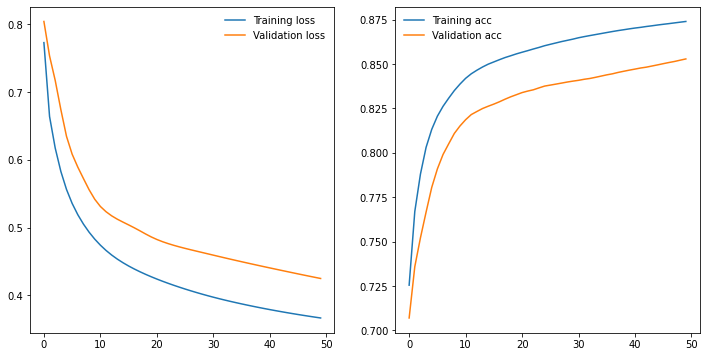

Acurácia de teste: 85.36%
Acurácia de treinamento: 87.40%
Acurácia de validação: 85.29%


In [ ]:
params3 = dict()
params3['EPOCHS'] = 50
params3['BATCH_SIZE'] = 64 
params3['LEARNING_RATE'] = 0.05
params3['CRITERION'] = nn.CrossEntropyLoss()
params3['OPTIMIZER'] = 'SGD'

model3 = nn.Sequential(
          nn.Linear(NUM_FEATURES, 128),
          nn.Tanh(),
          nn.Linear(128, NUM_CLASSES)
        )

execute_model(model3, params3)

# Análise do resultado do terceiro modelo

A acurácia no treino, teste e validação foram altas, com apenas 2% de variação para baixo do treino para teste/validação. Não há overfitting ou underfitting. 
O resultado ficou bem semelhante ao modelo anterior, porém, com menos ruído entre treino e validação.
Avaliando as épocas, as mesmas poderiam ser aumentadas, aumentado os neurônios e adicionadar uma camada escondida.

---

Quarto modelo: Rede neural com:


*   Camada de entrada com 512 neurônios
*   Função de ativação Tanh
*   Camada de escondida com 256 neurônios
*   Função de ativação Tanh
*   Camada de saída

Utilizarei 100 épocas, batch size de 64, LR de 0.05, função de otimização SGD e perda CrossEntropyLoss

Shape X_train (936408, 112)
Shape y_train (936408,)
Shape X_val (117052, 112)
Shape y_val (117052,)
Shape X_test (117051, 112)
Shape y_test (117051,)
Len DF original 1170511
Len train + val + test 1170511
Sequential(
  (0): Linear(in_features=112, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): Tanh()
  (4): Linear(in_features=256, out_features=12, bias=True)
)
Epoch: 1/100..  Train Loss: 0.7547..  Val Loss: 0.8289..  Train Acc: 0.7299..  Val Acc: 0.7054.. 
Epoch: 2/100..  Train Loss: 0.6272..  Val Loss: 0.7265..  Train Acc: 0.7814..  Val Acc: 0.7458.. 
Epoch: 3/100..  Train Loss: 0.5476..  Val Loss: 0.5883..  Train Acc: 0.8139..  Val Acc: 0.7944.. 
Epoch: 4/100..  Train Loss: 0.4980..  Val Loss: 0.5273..  Train Acc: 0.8331..  Val Acc: 0.8172.. 
Epoch: 5/100..  Train Loss: 0.4654..  Val Loss: 0.5186..  Train Acc: 0.8438..  Val Acc: 0.8209.. 
Epoch: 6/100..  Train Loss: 0.4426..  Val Loss: 0.5082..  Train Acc: 0.8508..  Val A

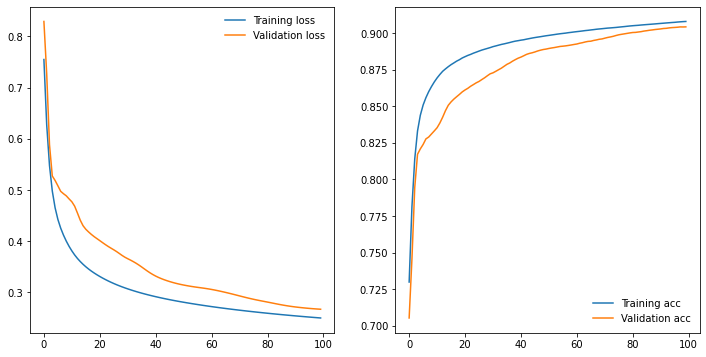

Acurácia de teste: 90.36%
Acurácia de treinamento: 90.79%
Acurácia de validação: 90.42%


In [ ]:
params4 = dict()
params4['EPOCHS'] = 100
params4['BATCH_SIZE'] = 64
params4['LEARNING_RATE'] = 0.05
params4['CRITERION'] = nn.CrossEntropyLoss()
params4['OPTIMIZER'] = 'SGD'

model4 = nn.Sequential(
          nn.Linear(NUM_FEATURES, 512),
          nn.Tanh(),
          nn.Linear(512, 256),
          nn.Tanh(),
          nn.Linear(256, NUM_CLASSES)
        )

execute_model(model4, params4)

# Análise do resultado do quarto modelo

A acurácia no treino, teste e validação foram as maiores entre os experimentos, com uma pequena variação para baixo do treino para teste/validação.
Notou-se nos gráficos que com o aumento das épocas, os dados foram melhor se ajustando ao modelo.

Não há overfitting ou underfitting. Modelo se apresenta bem no treino e também com baixa variação entre validação e teste.
Como o modelo se adaptou bem aos dados, utilizarei ele para realizar as predições do dataset hidden.
Notou-se que ainda poderia ser aumentada as épocas para incremento da acurácia, porém, para fins de entrega do trabalho, irei utilizar a arquitetura desse quarto modelo.

---

Salva o modelo 4

In [ ]:
#Salva modelo
torch.save(model4.state_dict(), 'checkpoint.pth')
print("Model:' \n\n", model4, '\n')
print("The state dict keys: \n\n", model4.state_dict().keys())

Model:' 

 Sequential(
  (0): Linear(in_features=112, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): Tanh()
  (4): Linear(in_features=256, out_features=12, bias=True)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


# **As instruções abaixo são para realizar a predição no hidden.csv e gerar o arquivo com as classificações para entrega**


Pequena avaliação no hidden.csv (dataset contendo somente as colunas preditoras)

In [ ]:
df_hidden = pd.read_csv('dataset_hidden.csv', delimiter=';')
print('Shape', df_hidden.shape)

Shape (122397, 30)


In [ ]:
df_hidden.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,1518.280,433906.75,6460000.5,-1493.241821,15.506232,-999.0,-999.000000,0.878615,-999.0,103.451515,...,-999.0,-999.0,0.229715,-0.000000,-999.0,-0.000000,0.000,-999.0,5,51
1,1518.432,433906.75,6460000.5,-1493.393799,18.524611,-999.0,-999.000000,0.874237,-999.0,94.124893,...,-999.0,-999.0,0.206369,1.616959,-999.0,9.326622,0.152,-999.0,5,51
2,1518.584,433906.75,6460000.5,-1493.545776,18.855669,-999.0,-999.000000,0.869858,-999.0,93.586487,...,-999.0,-999.0,0.205021,0.131363,-999.0,0.538406,0.152,-999.0,5,51
3,1518.736,433906.75,6460000.5,-1493.697754,19.163353,-999.0,-999.000000,0.865479,-999.0,91.113373,...,-999.0,-999.0,0.198831,1.637512,-999.0,2.473114,0.152,-999.0,5,51
4,1518.888,433906.75,6460000.5,-1493.849609,18.489744,-999.0,0.849849,0.863804,-999.0,100.228333,...,-999.0,-999.0,0.221647,0.819153,-999.0,-9.114960,0.152,-999.0,5,51


In [ ]:
df_hidden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122397 entries, 0 to 122396
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DEPTH_MD            122397 non-null  float64
 1   X_LOC               122397 non-null  float64
 2   Y_LOC               122397 non-null  float64
 3   Z_LOC               122397 non-null  float64
 4   CALI                122397 non-null  float64
 5   RSHA                122397 non-null  float64
 6   RMED                122397 non-null  float64
 7   RDEP                122397 non-null  float64
 8   RHOB                122397 non-null  float64
 9   GR                  122397 non-null  float64
 10  NPHI                122397 non-null  float64
 11  PEF                 122397 non-null  float64
 12  DTC                 122397 non-null  float64
 13  SP                  122397 non-null  float64
 14  BS                  122397 non-null  float64
 15  ROP                 122397 non-nul

Como realizei a normalização dos meus dados para treinar o modelo, tenho que fazer o mesmo com os dados do hidden.csv

In [ ]:
X_hidden_mm = min_max_scaler.transform(df_hidden[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',  'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP',
        'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'Carbon_Index', 'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB', 'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index'
        ]])

X_hidden_ohe = ohe.transform(df_hidden[['GROUP_encoded', 'FORMATION_encoded']])

X_hidden = np.hstack([ X_hidden_mm, X_hidden_ohe])

X_hidden = torch.from_numpy (X_hidden).float ()

#X_hidden = F.pad(X_hidden, (0, 22), "constant", 0)

Carrego o modelo e realizo a predição

In [ ]:
# Desativa o cálculo do gradiente (para modo evaluation) 
save_path = 'checkpoint.pth'
with torch.no_grad():
  model_predict = nn.Sequential(
          nn.Linear(NUM_FEATURES, 512),
          nn.Tanh(),
          nn.Linear(512, 256),
          nn.Tanh(),
          nn.Linear(256, NUM_CLASSES)
        )  #modelo 4
  model_predict.load_state_dict(torch.load(save_path))
  model_predict.eval() #ativa modo evaluation

  prediction = model_predict(X_hidden)
  classes_val = torch.argmax(prediction, dim=1)


In [ ]:
classes_val.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
df_entrega = pd.DataFrame(classes_val, columns=['lithology'])
print(df_entrega.shape)
df_entrega['lithology'].value_counts()

(122397, 1)


0     68044
1     14104
2     13315
3      9119
4      8862
7      5706
6      1680
10      833
5       568
8       127
9        39
Name: lithology, dtype: int64

Como eu havia padronizado as classes da variável a ser predita (FORCE_2020_LITHOFACIES_LITHOLOGY) no intervalo de 0-11, irei realizar a transformação contrária delas para voltarem ao valor original

In [ ]:
lithology_dict

{30000: 1,
 65030: 2,
 65000: 0,
 80000: 4,
 74000: 9,
 70000: 3,
 70032: 6,
 88000: 7,
 86000: 10,
 99000: 5,
 90000: 8,
 93000: 11}

In [ ]:
undo_lithology_dict = dict((y,x) for x,y in lithology_dict.items())

def undo_map_lithology(dict_lithology, row) -> str:
    key = row['lithology']
    return undo_lithology_dict[key]

df_entrega['lithology'] = df_entrega.apply(lambda row: undo_map_lithology(undo_lithology_dict, row), axis=1)
df_entrega['lithology'].value_counts()

65000    68044
30000    14104
65030    13315
70000     9119
80000     8862
88000     5706
70032     1680
86000      833
99000      568
90000      127
74000       39
Name: lithology, dtype: int64

In [ ]:
df_entrega.to_csv('hidden.csv', index=False)